In [ ]:
# !pip install spacy
# !python -m spacy download en_core_web_trf
!python -m spacy download en_core_web_sm
# !pip install spacy[cuda]
!pip install transformers
!pip install xformers


2023-09-04 11:45:24.349728: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 40.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
from transformers import pipeline
import pandas as pd
import torch
import time
from tqdm import tqdm




# Load pre-trained sentiment analysis model with GPU support
sentiment_analysis_model = pipeline('sentiment-analysis', device=0)  # Use device 0 for GPU

df = pd.read_csv("/content/Twiter_Sentiment.csv")
sentence = df["text"].tolist()
label = df["label"].tolist()

# Define the maximum sequence length supported by the model
max_seq_length = 512

# Initialize a list to store the sentiment predictions
predicted_results = []

# Measure the start time
start_time = time.time()

# Use tqdm to display a progress bar with time and percentage
with tqdm(total=len(sentence), desc="Processing") as pbar:
    for i in sentence:
        # Truncate or pad the sentence to fit within the model's maximum sequence length
        truncated_i = i[:max_seq_length]  # Truncate if longer

        # Get sentiment prediction for the truncated sentence
        sentiment = sentiment_analysis_model(truncated_i)[0]
        predicted_results.append(sentiment)

        # Update the progress bar
        pbar.update(1)
        pbar.set_postfix({"Time": f"{time.time() - start_time:.2f} s"})

# Measure the end time
end_time = time.time()

# Calculate the time taken for the loop
loop_time = end_time - start_time

# Calculate the percentage completed
percentage_completed = len(predicted_results) / len(sentence) * 100

print(f"Loop time: {loop_time:.2f} seconds")
print(f"Processing completed: {percentage_completed:.2f}%")


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Processing:   0%|          | 10/5000 [00:00<01:02, 80.25it/s, Time=0.13 s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Processing: 100%|██████████| 5000/5000 [01:18<00:00, 63.74it/s, Time=78.45 s]

Loop time: 78.45 seconds
Processing completed: 100.00%


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Processing:   0%|          | 10/5000 [00:00<01:23, 59.86it/s, Time=0.17 s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Processing: 100%|██████████| 5000/5000 [01:04<00:00, 77.81it/s, Time=64.26 s]


Loop time: 64.26 seconds
Processing completed: 100.00%


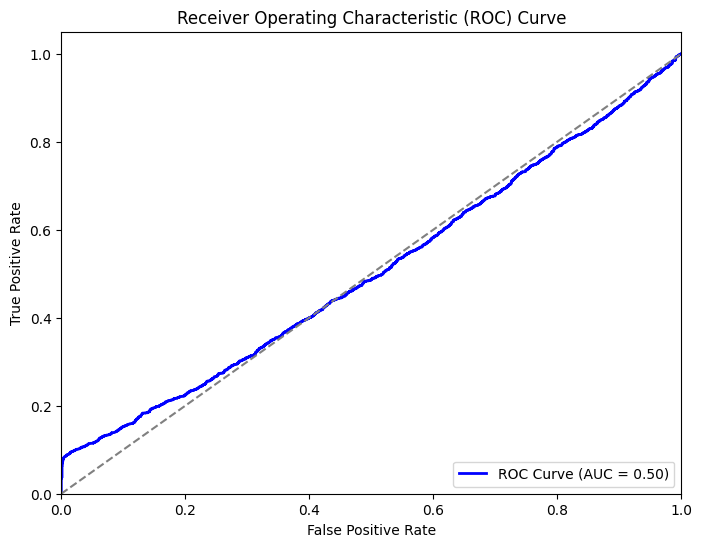

AUC (Area Under the Curve): 0.50


In [ ]:
from transformers import pipeline
import pandas as pd
import time
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Load pre-trained sentiment analysis model with GPU support
sentiment_analysis_model = pipeline('sentiment-analysis', device=0)  # Use device 0 for GPU

df = pd.read_csv("/content/Twiter_Sentiment.csv")
sentence = df["text"].tolist()
label = df["label"].tolist()

# Define the maximum sequence length supported by the model
max_seq_length = 512

# Initialize lists to store the true labels and predicted probabilities
true_labels = []
predicted_probabilities = []

# Measure the start time
start_time = time.time()

# Use tqdm to display a progress bar with time and percentage
with tqdm(total=len(sentence), desc="Processing") as pbar:
    for i in sentence:
        # Truncate or pad the sentence to fit within the model's maximum sequence length
        truncated_i = i[:max_seq_length]  # Truncate if longer

        # Get sentiment prediction for the truncated sentence
        sentiment = sentiment_analysis_model(truncated_i)[0]
        predicted_probabilities.append(sentiment['score'])  # Store the probability score
        true_labels.append(label[pbar.n])  # Store the true label

        # Update the progress bar
        pbar.update(1)
        pbar.set_postfix({"Time": f"{time.time() - start_time:.2f} s"})

# Measure the end time
end_time = time.time()

# Calculate the time taken for the loop
loop_time = end_time - start_time

# Calculate the percentage completed
percentage_completed = len(predicted_probabilities) / len(sentence) * 100

print(f"Loop time: {loop_time:.2f} seconds")
print(f"Processing completed: {percentage_completed:.2f}%")

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)

# Calculate the AUC (Area Under the Curve)
auc = roc_auc_score(true_labels, predicted_probabilities)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print(f"AUC (Area Under the Curve): {auc:.2f}")


In [ ]:
correct_predictions = 0
total_predictions = len(predicted_results)
p_label=[]
for predicted_label in predicted_results:
    if predicted_label['label'] == 'POSITIVE':
      p_label.append(1)
    else:
      p_label.append(0)

for predicted_label, true_label in zip(predicted_results, label):
    if (predicted_label['label'] == 'POSITIVE' and true_label == 1) or (predicted_label['label'] == 'NEGATIVE' and true_label == 0):
        correct_predictions += 1


accuracy = correct_predictions / total_predictions
print("Accuracy:", accuracy)
df

Accuracy: 0.832


,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0
...,...,...
4995,This is the kind of picture John Lassiter woul...,1
4996,A MUST SEE! I saw WHIPPED at a press screening...,1
4997,NBC should be ashamed. I wouldn't allow my chi...,0
4998,This movie is a clumsy mishmash of various gho...,0


In [ ]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score

# Convert the predicted sentiments to labels (positive or negative)



#print(label[:100])
# Calculate the accuracy
accuracy = accuracy_score(label, p_label)

print(f"Accuracy: {accuracy * 100:.2f}%")
precision = precision_score(label, p_label)

# Calculate recall
recall = recall_score(label, p_label)

# Calculate F1 score
f1 = f1_score(label, p_label)

print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")


Accuracy: 83.20%
Precision: 84.99%
Recall: 80.72%
F1 Score: 82.80%


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample

# Load your data (replace with your data loading code)
df = pd.read_csv("/content/Twiter_Sentiment.csv")

# Split the data into features and labels
X = df["text"].tolist()
y = df["label"].tolist()

# Define the model you want to evaluate (replace with your model)
from transformers import pipeline
sentiment_analysis_model = pipeline('sentiment-analysis', device=0)  # Use device 0 for GPU

# Define the maximum sequence length supported by the model
max_seq_length = 512

# Initialize lists to store performance metrics
train_sizes = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Define a range of training data sizes you want to evaluate
training_data_sizes = np.arange(0.1, 1.0, 0.1)  # E.g., 10%, 20%, ..., 90%

# Split your data into a fixed testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Number of bootstrap iterations for confidence intervals
n_bootstrap_iterations = 100

for train_size in training_data_sizes:
    # Determine the number of samples to use for training based on train_size
    num_samples = int(train_size * len(X_train))

    # Create a subset of the training data
    X_subset = X_train[:num_samples]
    y_subset = y_train[:num_samples]

    # Perform sentiment analysis and obtain predicted labels
    predicted_results_subset = []
    for i in X_subset:
        truncated_i = i[:max_seq_length]
        sentiment = sentiment_analysis_model(truncated_i)[0]
        predicted_results_subset.append(sentiment)

    # Convert the predicted sentiments to labels (positive or negative)
    p_label_subset = [1 if result['label'] == 'POSITIVE' else 0 for result in predicted_results_subset]

    # Initialize lists to store bootstrapped metric values
    bootstrap_accuracy = []
    bootstrap_precision = []
    bootstrap_recall = []
    bootstrap_f1 = []

    # Perform bootstrapping for confidence intervals
    for _ in range(n_bootstrap_iterations):
        # Resample the data with replacement
        resampled_X, resampled_y = resample(X_subset, y_subset, random_state=42)

        # Perform sentiment analysis and obtain predicted labels on resampled data
        resampled_predicted_results = []
        for i in resampled_X:
            truncated_i = i[:max_seq_length]
            sentiment = sentiment_analysis_model(truncated_i)[0]
            resampled_predicted_results.append(sentiment)

        # Convert the predicted sentiments to labels (positive or negative)
        resampled_p_label = [1 if result['label'] == 'POSITIVE' else 0 for result in resampled_predicted_results]

        # Calculate and store metric values for the resampled data
        bootstrap_accuracy.append(accuracy_score(resampled_y, resampled_p_label))
        bootstrap_precision.append(precision_score(resampled_y, resampled_p_label))
        bootstrap_recall.append(recall_score(resampled_y, resampled_p_label))
        bootstrap_f1.append(f1_score(resampled_y, resampled_p_label))

    # Calculate the mean and confidence intervals for each metric
    mean_accuracy = np.mean(bootstrap_accuracy)
    ci_accuracy = np.percentile(bootstrap_accuracy, [2.5, 97.5])

    mean_precision = np.mean(bootstrap_precision)
    ci_precision = np.percentile(bootstrap_precision, [2.5, 97.5])

    mean_recall = np.mean(bootstrap_recall)
    ci_recall = np.percentile(bootstrap_recall, [2.5, 97.5])

    mean_f1 = np.mean(bootstrap_f1)
    ci_f1 = np.percentile(bootstrap_f1, [2.5, 97.5])

    # Append to the lists
    train_sizes.append(num_samples)
    accuracy_scores.append(mean_accuracy)
    precision_scores.append(mean_precision)
    recall_scores.append(mean_recall)
    f1_scores.append(mean_f1)

    # Print the metric values with confidence intervals
    print(f"Train Size: {num_samples}")
    print(f"Accuracy: {mean_accuracy:.2f} ({ci_accuracy[0]:.2f} - {ci_accuracy[1]:.2f})")
    print(f"Precision: {mean_precision:.2f} ({ci_precision[0]:.2f} - {ci_precision[1]:.2f})")
    print(f"Recall: {mean_recall:.2f} ({ci_recall[0]:.2f} - {ci_recall[1]:.2f})")
    print(f"F1 Score: {mean_f1:.2f} ({ci_f1[0]:.2f} - {ci_f1[1]:.2f})")
    print()

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, accuracy_scores, label='Accuracy')
plt.fill_between(train_sizes, [ci[0] for ci in ci_accuracy], [ci[1] for ci in ci_accuracy], alpha=0.2)
plt.plot(train_sizes, precision_scores, label='Precision')
plt.fill_between(train_sizes, [ci[0] for ci in ci_precision], [ci[1] for ci in ci_precision], alpha=0.2)
plt.plot(train_sizes, recall_scores, label='Recall')
plt.fill_between(train_sizes, [ci[0] for ci in ci_recall], [ci[1] for ci in ci_recall], alpha=0.2)
plt.plot(train_sizes, f1_scores, label='F1 Score')
plt.fill_between(train_sizes, [ci[0] for ci in ci_f1], [ci[1] for ci in ci_f1], alpha=0.2)
plt.xlabel('Training Data Size')
plt.ylabel('Metric Value')
plt.title('Learning Curves with Confidence Intervals')
plt.legend()
plt.grid()
plt.show()




No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: 

Train Size: 400
Accuracy: 0.84 (0.84 - 0.84)
Precision: 0.86 (0.86 - 0.86)
Recall: 0.77 (0.77 - 0.77)
F1 Score: 0.81 (0.81 - 0.81)



/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentiall

Train Size: 800
Accuracy: 0.83 (0.83 - 0.83)
Precision: 0.85 (0.85 - 0.85)
Recall: 0.80 (0.80 - 0.80)
F1 Score: 0.82 (0.82 - 0.82)



/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentiall

Train Size: 1200
Accuracy: 0.83 (0.83 - 0.83)
Precision: 0.85 (0.85 - 0.85)
Recall: 0.80 (0.80 - 0.80)
F1 Score: 0.82 (0.82 - 0.82)



/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentiall

Train Size: 1600
Accuracy: 0.82 (0.82 - 0.82)
Precision: 0.85 (0.85 - 0.85)
Recall: 0.79 (0.79 - 0.79)
F1 Score: 0.82 (0.82 - 0.82)



/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentiall

Train Size: 2000
Accuracy: 0.83 (0.83 - 0.83)
Precision: 0.85 (0.85 - 0.85)
Recall: 0.80 (0.80 - 0.80)
F1 Score: 0.82 (0.82 - 0.82)



/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentiall

Train Size: 2400
Accuracy: 0.84 (0.84 - 0.84)
Precision: 0.86 (0.86 - 0.86)
Recall: 0.80 (0.80 - 0.80)
F1 Score: 0.83 (0.83 - 0.83)



/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentiall

Train Size: 2800
Accuracy: 0.84 (0.84 - 0.84)
Precision: 0.86 (0.86 - 0.86)
Recall: 0.80 (0.80 - 0.80)
F1 Score: 0.83 (0.83 - 0.83)



/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentiall

Train Size: 3200
Accuracy: 0.84 (0.84 - 0.84)
Precision: 0.86 (0.86 - 0.86)
Recall: 0.81 (0.81 - 0.81)
F1 Score: 0.83 (0.83 - 0.83)



/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentiall

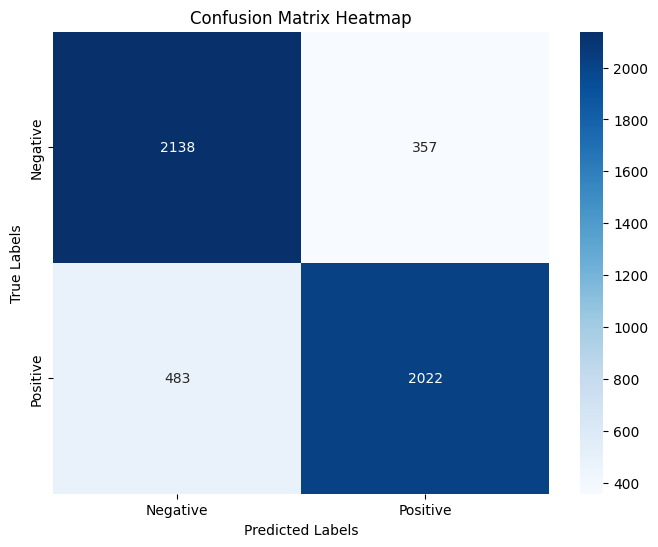

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the confusion matrix values
confusion_matrix = [[true_negatives, false_positives],
                    [false_negatives, true_positives]]

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()



In [ ]:
print(label[:100])

[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0]


In [ ]:
pip install dash
